In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
#import the required libraries
import numpy as np 
import pandas as pd 
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import pickle
import seaborn as sns 
import matplotlib.ticker as mtick  
import matplotlib.pyplot as plt
%matplotlib inline

#### Loading the data file

In [3]:
path = "customer_churn_large_dataset.xlsx"
Main_dataset = pd.read_excel(path)


In [4]:
## print shape of dataset with rows and columns
print(Main_dataset.shape)

(100000, 9)


In [5]:
Main_dataset.head()

,CustomerID,Name,Age,Gender,Location,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Churn
0,1,Customer_1,63,Male,Los Angeles,17,73.36,236,0
1,2,Customer_2,62,Female,New York,1,48.76,172,0
2,3,Customer_3,24,Female,Los Angeles,5,85.47,460,0
3,4,Customer_4,36,Female,Miami,3,97.94,297,1
4,5,Customer_5,46,Female,Miami,19,58.14,266,0


In [6]:
Main_dataset.columns

Index(['CustomerID', 'Name', 'Age', 'Gender', 'Location',
       'Subscription_Length_Months', 'Monthly_Bill', 'Total_Usage_GB',
       'Churn'],
      dtype='object')

In [7]:
Main_dataset.describe()

,CustomerID,Age,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Churn
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,50000.500000,44.027020,12.490100,65.053197,274.393650,0.497790
std,28867.657797,15.280283,6.926461,20.230696,130.463063,0.499998
min,1.000000,18.000000,1.000000,30.000000,50.000000,0.000000
25%,25000.750000,31.000000,6.000000,47.540000,161.000000,0.000000
50%,50000.500000,44.000000,12.000000,65.010000,274.000000,0.000000
75%,75000.250000,57.000000,19.000000,82.640000,387.000000,1.000000
max,100000.000000,70.000000,24.000000,100.000000,500.000000,1.000000


#### Here we can see that 75% people who are not likely to churn are :
- People who are younger than age 57
- Use lesser than 387 GB 
- Has subscription for less than 19 months 
- Monthly bill less than 82.64 units

#### The remaining 25% people who are most likely to churn are :
- People who are older than age 57
- Use more than 387 GB 
- Has subscription for more than 19 months 
- Monthly bill more than 82.64 units

In [8]:
Main_dataset.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   CustomerID                  100000 non-null  int64  
 1   Name                        100000 non-null  object 
 2   Age                         100000 non-null  int64  
 3   Gender                      100000 non-null  object 
 4   Location                    100000 non-null  object 
 5   Subscription_Length_Months  100000 non-null  int64  
 6   Monthly_Bill                100000 non-null  float64
 7   Total_Usage_GB              100000 non-null  int64  
 8   Churn                       100000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 6.9+ MB


#### the columns are in desired data types

### Checking the distribution of the target variable

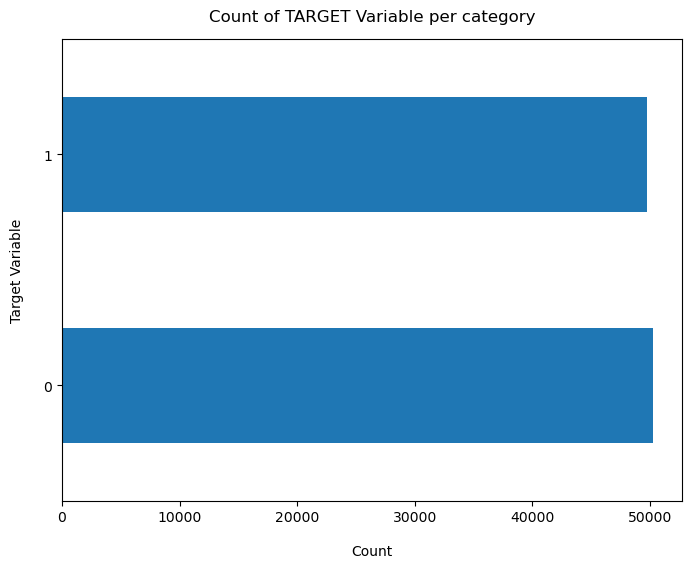

In [9]:
Main_dataset['Churn'].value_counts().plot(kind='barh', figsize=(8, 6))
plt.xlabel("Count", labelpad=14)
plt.ylabel("Target Variable", labelpad=14)
plt.title("Count of TARGET Variable per category", y=1.02);

In [10]:
100*Main_dataset['Churn'].value_counts()/len(Main_dataset['Churn'])

0    50.221
1    49.779
Name: Churn, dtype: float64

In [11]:
Main_dataset['Churn'].value_counts()

0    50221
1    49779
Name: Churn, dtype: int64

#### Here we can conclude that our data is balanced

# EDA

### Data Cleaning
#### Checking for missing data

In [12]:
Main_dataset.isnull().sum()

CustomerID                    0
Name                          0
Age                           0
Gender                        0
Location                      0
Subscription_Length_Months    0
Monthly_Bill                  0
Total_Usage_GB                0
Churn                         0
dtype: int64

#### Here we can see that we don't have any missing values in this data

#### I am dropping CustomerID and Name features

In [13]:
dataset = Main_dataset.drop(['CustomerID','Name'],axis=1)

In [14]:
# list of categoriacal variables
categorical_features=[feature for feature in dataset.columns if dataset[feature].dtypes == 'O' and  len(Main_dataset[feature].unique())<25]

print("Categoriacal Variables Count: {}".format(len(categorical_features)))
categorical_features

Categoriacal Variables Count: 2


['Gender', 'Location']

#### 1. Plot distibution of individual predictors by churn

### Univariate Analysis

<Figure size 640x480 with 0 Axes>

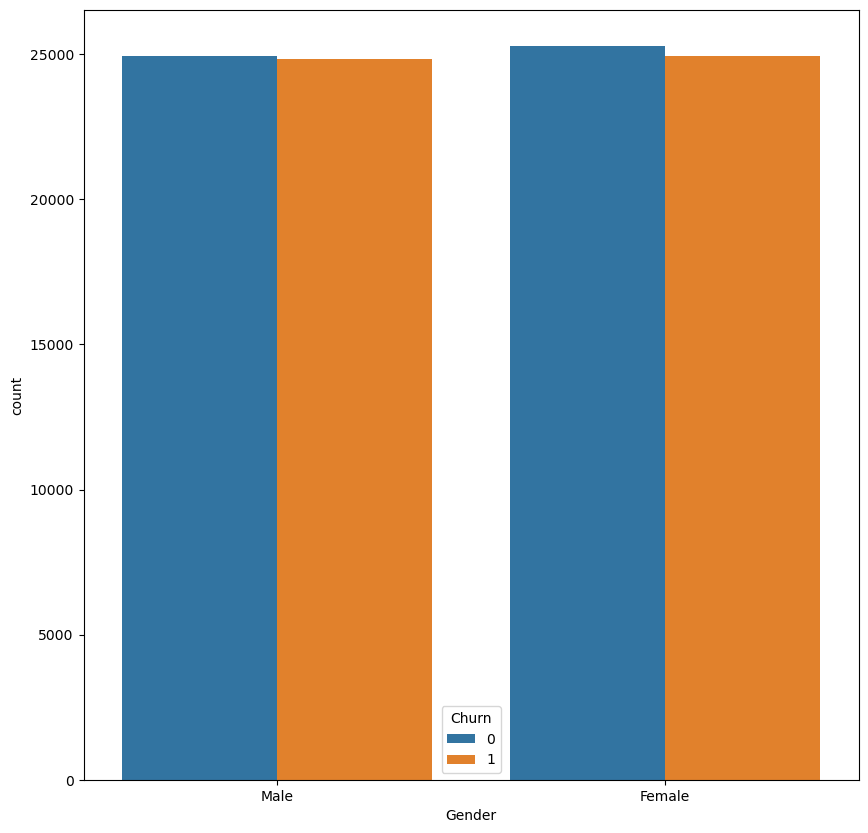

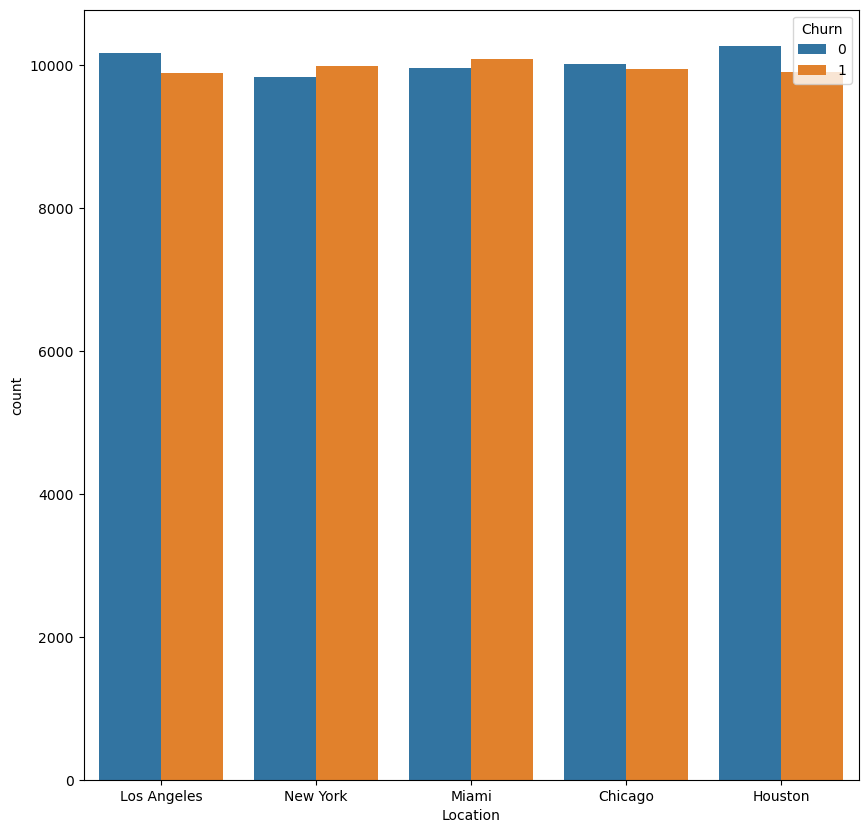

In [15]:
for i, predictor in enumerate(dataset[categorical_features]):
    plt.figure(i)
    plt.figure(figsize=(10,10 ))
    sns.countplot(data=dataset, x=predictor, hue ='Churn')

#### Here we can see that the categorical variables are evenly distributed

In [16]:
# list of numerical variables
numerical_features = [feature for feature in dataset.columns if dataset[feature].dtypes != 'O']

print('Number of numerical variables: ', len(numerical_features))
numerical_features

Number of numerical variables:  5


['Age',
 'Subscription_Length_Months',
 'Monthly_Bill',
 'Total_Usage_GB',
 'Churn']

In [17]:
dataset[numerical_features].head()


,Age,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Churn
0,63,17,73.36,236,0
1,62,1,48.76,172,0
2,24,5,85.47,460,0
3,36,3,97.94,297,1
4,46,19,58.14,266,0


In [18]:
## Numerical variables are usually of 2 type
## 1. Continous variable and Discrete Variables

discrete_feature=[feature for feature in numerical_features if len(dataset[feature].unique())<20 and feature != 'Churn']
print("Discrete Variables Count: {}".format(len(discrete_feature)))

Discrete Variables Count: 0


In [19]:
## Numerical variables are usually of 2 type
## 1. Continous variable and Discrete Variables

continuous_feature=[feature for feature in numerical_features if len(dataset[feature].unique())>20 and feature != 'Churn']
print("Continous Variables Count: {}".format(len(continuous_feature)))
continuous_feature

Continous Variables Count: 4


['Age', 'Subscription_Length_Months', 'Monthly_Bill', 'Total_Usage_GB']

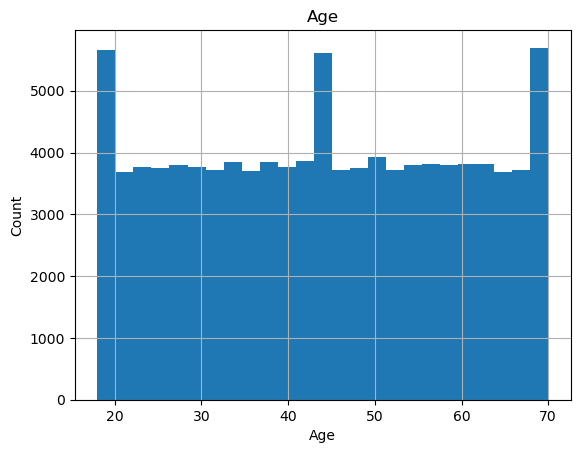

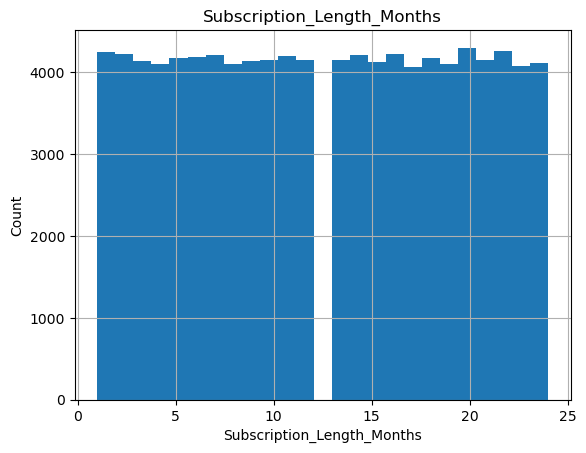

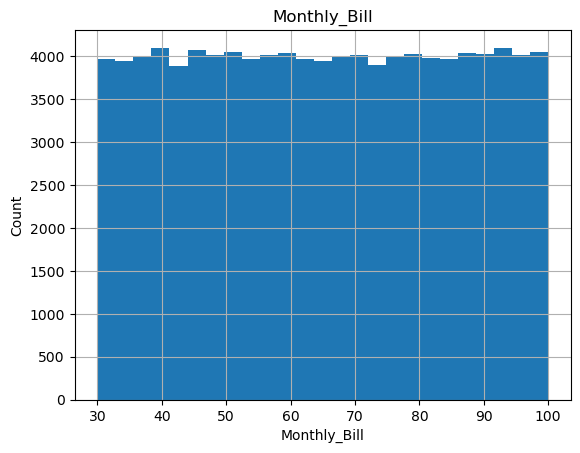

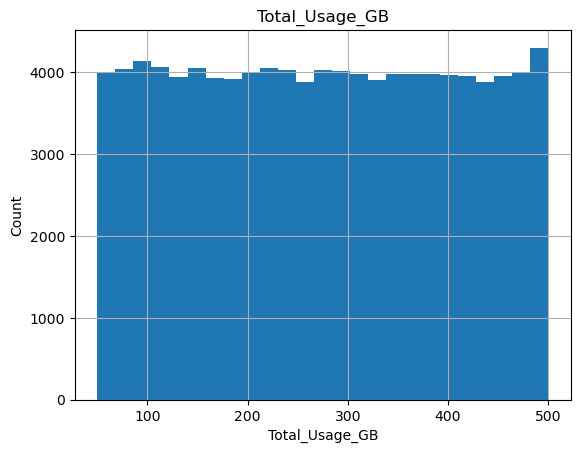

In [20]:
## Lets analyse the continuous values by creating histograms to understand the distribution

for feature in continuous_feature:
    data=dataset.copy()
    dataset[feature].hist(bins=25)
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.title(feature)
    plt.show()

### Now we are encoding the categorical data

In [21]:
data=dataset.copy()
for feature in categorical_features:
    labels_ordered=data.groupby([feature])['Churn'].mean().sort_values().index
    labels_ordered={k:i for i,k in enumerate(labels_ordered,0)}

    data[feature]=data[feature].map(labels_ordered)

In [22]:
labels_ordered

{'Houston': 0, 'Los Angeles': 1, 'Chicago': 2, 'Miami': 3, 'New York': 4}

In [23]:
data

,Age,Gender,Location,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Churn
0,63,1,1,17,73.36,236,0
1,62,0,4,1,48.76,172,0
2,24,0,1,5,85.47,460,0
3,36,0,3,3,97.94,297,1
4,46,0,3,19,58.14,266,0
...,...,...,...,...,...,...,...
99995,33,1,0,23,55.13,226,1
99996,62,0,4,19,61.65,351,0
99997,64,1,2,17,96.11,251,1
99998,51,0,4,20,49.25,434,1


#### Build a corelation of all predictors with 'Churn'

<Axes: >

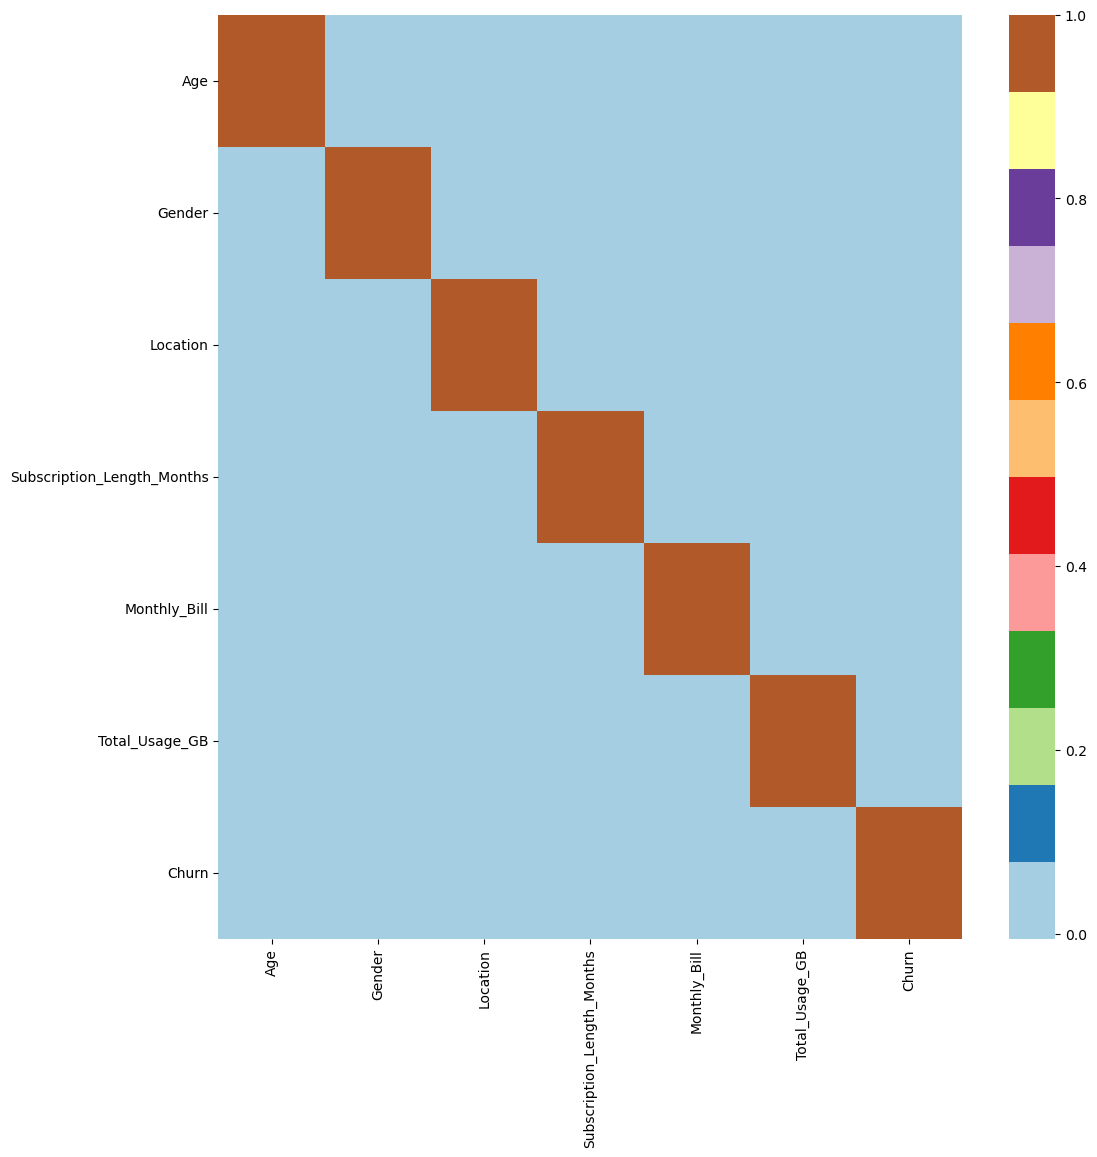

In [24]:
plt.figure(figsize=(12,12))
sns.heatmap(data.corr(), cmap="Paired")

#### Here we don't see any special correlation among the parameters

### Bivariate Analysis


In [25]:
new_df1_target0=dataset.loc[dataset["Churn"]==0]
new_df1_target1=dataset.loc[dataset["Churn"]==1]

In [26]:
def uniplot(df,col,title,hue =None):
    
    sns.set_style('whitegrid')
    sns.set_context('talk')
    plt.rcParams["axes.labelsize"] = 20
    plt.rcParams['axes.titlesize'] = 22
    plt.rcParams['axes.titlepad'] = 30
    
    
    temp = pd.Series(data = hue)
    fig, ax = plt.subplots()
    width = len(df[col].unique()) + 7 + 4*len(temp.unique())
    fig.set_size_inches(width , 8)
    plt.xticks(rotation=45)
    plt.yscale('log')
    plt.title(title)
    ax = sns.countplot(data = df, x= col, order=df[col].value_counts().index,hue = hue,palette='bright') 
        
    plt.show()

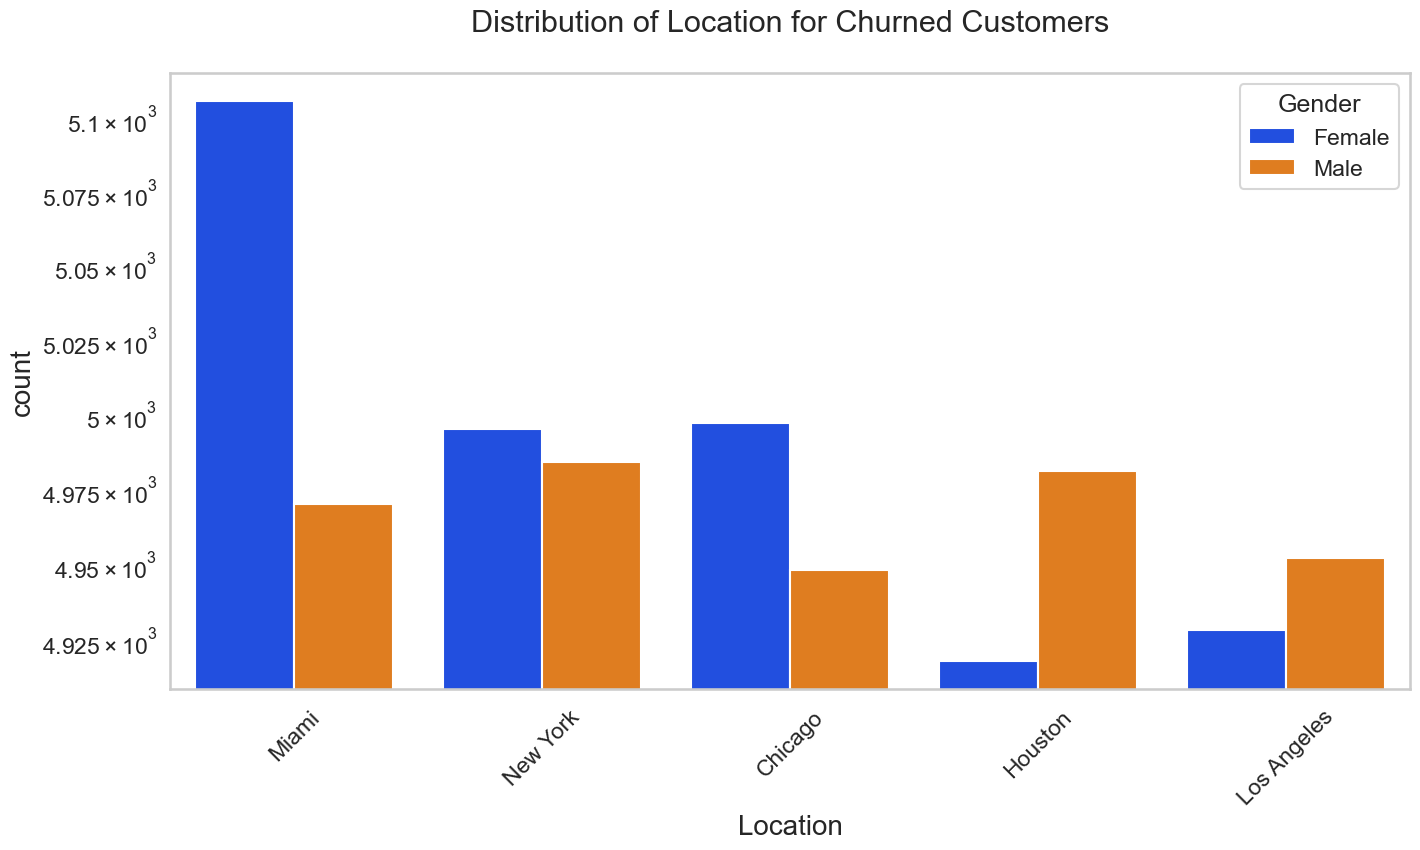

In [27]:
uniplot(new_df1_target1,col='Location',title='Distribution of Location for Churned Customers',hue='Gender')

#### Here we can see that the Female cutomers from Miami has got churned the most

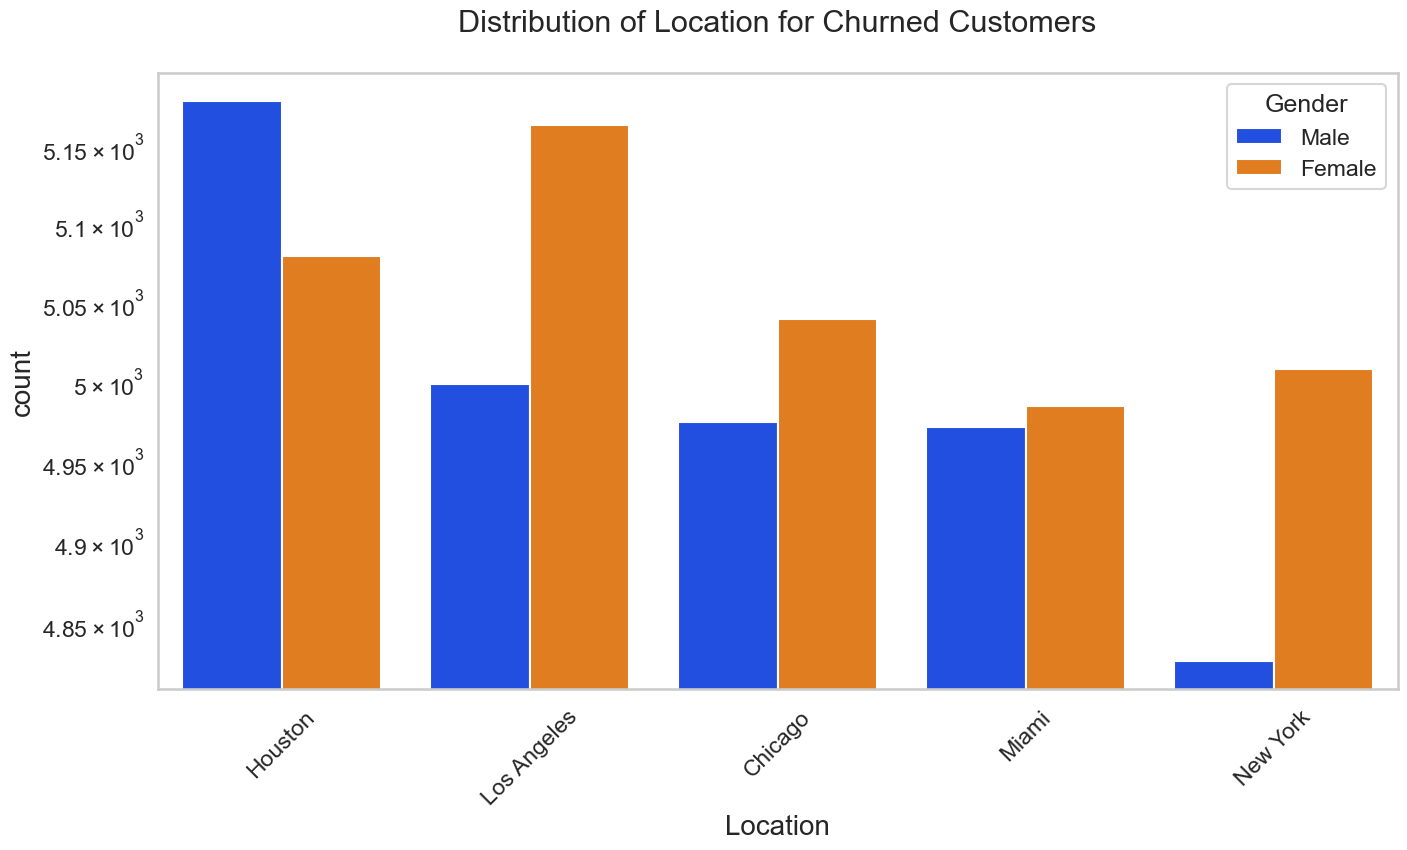

In [28]:
uniplot(new_df1_target0,col='Location',title='Distribution of Location for Churned Customers',hue='Gender')

#### Here we can see that the Female cutomers from Los Angeles and Male customers from Houston has got churned the least

# Train Test Split

In [29]:
from sklearn.model_selection import train_test_split


In [30]:
features = [feature for feature in data if feature != 'Churn' ]

In [31]:
x= data[features]
y = data["Churn"]

In [32]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

print(type(x_train))
print(type(y_train))
print(type(x_test))
print(type(y_test))

(67000, 6)
(67000,)
(33000, 6)
(33000,)
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


### Feature Selection

In [33]:
# Define feature selection
from sklearn.feature_selection import f_classif,SelectKBest 
fs = SelectKBest(score_func=f_classif,k=3)

In [34]:
# Apply feature selection
fs.fit(x_train, y_train)

SelectKBest(k=3)

In [35]:
# True = Top 5 columns as we mentioned k = 3
# False = Allthe remaining columns excpet k = 3
fs.get_support()

array([ True, False,  True, False,  True, False])

In [36]:
# let's print the number of total and selected features

# this is how we can make a list of the selected features
selected_feat = x_train.columns[(fs.get_support())]
selected_feat

Index(['Age', 'Location', 'Monthly_Bill'], dtype='object')

In [37]:
import math
def list_ceil(x):
    return[math.ceil(i) for i in x]
print("P_Values :")
print(np.round(fs.pvalues_,4))
print("F Values :")
print(fs.scores_)


P_Values :
[0.1944 0.7897 0.0214 0.7265 0.392  0.589 ]
F Values :
[1.68397026 0.07114018 5.29558409 0.12234231 0.73263151 0.2918399 ]


In [38]:
list_ceil(fs.scores_)

[2, 1, 6, 1, 1, 1]

In [39]:
features_score = pd.DataFrame(fs.scores_)
features_pvalue = pd.DataFrame(np.round(fs.pvalues_,4))
features = pd.DataFrame(x_train.columns)
feature_score = pd.concat([features,features_score,features_pvalue],axis=1)
# Assign the column name
feature_score.columns = ["Input_Features","Score","P_Value"]
print(feature_score.nlargest(3,columns="Score"))

  Input_Features     Score  P_Value
2       Location  5.295584   0.0214
0            Age  1.683970   0.1944
4   Monthly_Bill  0.732632   0.3920


In [40]:
# let's print some stats
print('total features: {}'.format((x_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))

total features: 6
selected features: 3


In [41]:
data.columns

Index(['Age', 'Gender', 'Location', 'Subscription_Length_Months',
       'Monthly_Bill', 'Total_Usage_GB', 'Churn'],
      dtype='object')

In [42]:
selected_feat

Index(['Age', 'Location', 'Monthly_Bill'], dtype='object')

In [43]:
x_train = x_train[selected_feat]
x_test = x_test[selected_feat]

In [44]:
x_train.head()


,Age,Location,Monthly_Bill
59428,45,0,31.67
34957,68,1,63.26
4264,28,2,53.31
53791,58,3,91.08
82114,56,1,53.19


In [45]:
y_train.head()


59428    1
34957    0
4264     1
53791    1
82114    1
Name: Churn, dtype: int64

## Trying out various classifiers on the cleaned dataset

In [46]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt


from sklearn.metrics import mean_absolute_error,r2_score,classification_report,confusion_matrix


def train_model(m,name):
    model = m
    model.fit(x_train, y_train)
    predictions = model.predict(x_test)
    print(f"\n{name}")
    print(classification_report(y_test, predictions))



train_model(DecisionTreeClassifier(),"Decision Tree Classifier")
train_model(RandomForestClassifier(random_state=3),"Random Forest Classifier")   
train_model(XGBClassifier(n_estimators=600),"XGBoost Classifier")   
train_model(GradientBoostingClassifier(random_state=1),"Gradient Classifier")   
train_model(ExtraTreesClassifier(),"Extra Trees Classifier")   
train_model(LogisticRegression(),"Logistic Regression")



Decision Tree Classifier
              precision    recall  f1-score   support

           0       0.51      0.51      0.51     16638
           1       0.50      0.49      0.50     16362

    accuracy                           0.50     33000
   macro avg       0.50      0.50      0.50     33000
weighted avg       0.50      0.50      0.50     33000


Random Forest Classifier
              precision    recall  f1-score   support

           0       0.50      0.50      0.50     16638
           1       0.50      0.50      0.50     16362

    accuracy                           0.50     33000
   macro avg       0.50      0.50      0.50     33000
weighted avg       0.50      0.50      0.50     33000


XGBoost Classifier
              precision    recall  f1-score   support

           0       0.50      0.50      0.50     16638
           1       0.49      0.49      0.49     16362

    accuracy                           0.50     33000
   macro avg       0.50      0.50      0.50     33000
we

#### Here we can see that all the classifier is giving 50%, so we would try to find better way for model building

### Using SMOTEENN 

In [47]:
from imblearn.combine import SMOTEENN


In [48]:
sm = SMOTEENN()
X_resampled, y_resampled = sm.fit_resample(x_train,y_train)
xr_train,xr_test,yr_train,yr_test=train_test_split(X_resampled, y_resampled,test_size=0.2)

In [49]:
def train_model_Smoteenn(m,name):
    xr_train,xr_test,yr_train,yr_test=train_test_split(X_resampled, y_resampled,test_size=0.2)
    model_dt_smote = m
    model_dt_smote.fit(xr_train,yr_train)
    yr_predict = model_dt_smote.predict(xr_test)
    model_score_r = model_dt_smote.score(xr_test, yr_test)
    print(name)
    print(classification_report(yr_test, yr_predict))

In [50]:
train_model_Smoteenn(DecisionTreeClassifier(),"Decision Tree Classifier")
train_model_Smoteenn(RandomForestClassifier(random_state=3),"Random Forest Classifier")   
train_model_Smoteenn(XGBClassifier(n_estimators=600),"XGBoost Classifier")   
train_model_Smoteenn(GradientBoostingClassifier(random_state=1),"Gradient Classifier")   
train_model_Smoteenn(ExtraTreesClassifier(),"Extra Trees Classifier")   
train_model_Smoteenn(LogisticRegression(),"Logistic Regression")

Decision Tree Classifier
              precision    recall  f1-score   support

           0       0.84      0.85      0.85       827
           1       0.86      0.85      0.85       882

    accuracy                           0.85      1709
   macro avg       0.85      0.85      0.85      1709
weighted avg       0.85      0.85      0.85      1709

Random Forest Classifier
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       865
           1       0.89      0.88      0.89       844

    accuracy                           0.89      1709
   macro avg       0.89      0.89      0.89      1709
weighted avg       0.89      0.89      0.89      1709

XGBoost Classifier
              precision    recall  f1-score   support

           0       0.77      0.81      0.79       843
           1       0.80      0.77      0.79       866

    accuracy                           0.79      1709
   macro avg       0.79      0.79      0.79      1709
weigh

#### By using SMOTEENN we are getting much better result, Extra Trees Classifier has provided 91% accuracy with SMOTEENN so I am chosing it as the final model

In [51]:
xr_train,xr_test,yr_train,yr_test=train_test_split(X_resampled, y_resampled,test_size=0.2)
model_dt_smote = ExtraTreesClassifier()
model_dt_smote.fit(xr_train,yr_train)
yr_predict = model_dt_smote.predict(xr_test)
model_score_r = model_dt_smote.score(xr_test, yr_test)
print('Extra Trees Classifier')
print(classification_report(yr_test, yr_predict))

Extra Trees Classifier
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       832
           1       0.92      0.89      0.90       877

    accuracy                           0.90      1709
   macro avg       0.90      0.90      0.90      1709
weighted avg       0.90      0.90      0.90      1709



In [52]:
print(confusion_matrix(yr_test, yr_predict))

[[761  71]
 [ 94 783]]


# Saving model as a pickle file

In [53]:
import pickle

filename = 'model.pkl'

pickle.dump(model_dt_smote, open(filename, 'wb'))

### The saved model is working Correctly

In [54]:
load_model = pickle.load(open(filename, 'rb'))

model_score_r = load_model.score(xr_test, yr_test)

print('Extra Trees Classifier')
print(classification_report(yr_test, yr_predict))

Extra Trees Classifier
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       832
           1       0.92      0.89      0.90       877

    accuracy                           0.90      1709
   macro avg       0.90      0.90      0.90      1709
weighted avg       0.90      0.90      0.90      1709



### Making a preprocessor pipeline

In [55]:
dataset[['Age','Location','Monthly_Bill','Churn']]

,Age,Location,Monthly_Bill,Churn
0,63,Los Angeles,73.36,0
1,62,New York,48.76,0
2,24,Los Angeles,85.47,0
3,36,Miami,97.94,1
4,46,Miami,58.14,0
...,...,...,...,...
99995,33,Houston,55.13,1
99996,62,New York,61.65,0
99997,64,Chicago,96.11,1
99998,51,New York,49.25,1


In [56]:
# Custom Transformer to preprocess categorical features
class CategoricalFeatureProcessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.labels_mappings = {}
        for feature in categorical_features:
            labels_ordered = X.groupby([feature])['Churn'].mean().sort_values().index
            self.labels_mappings[feature] = {label: index for index, label in enumerate(labels_ordered)}
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        for feature in categorical_features:
            X_transformed[feature] = X_transformed[feature].map(self.labels_mappings[feature])
        return X_transformed

# Define categorical features
categorical_features = ['Location']

# Create a pipeline
pipeline = Pipeline([
    ('categorical_processor', CategoricalFeatureProcessor())
])



# Fit and transform the dataset using the pipeline
preprocessed_data = pipeline.fit_transform(dataset[['Age','Location','Monthly_Bill','Churn']])

In [57]:
data[['Age','Location','Monthly_Bill','Churn']]


,Age,Location,Monthly_Bill,Churn
0,63,1,73.36,0
1,62,4,48.76,0
2,24,1,85.47,0
3,36,3,97.94,1
4,46,3,58.14,0
...,...,...,...,...
99995,33,0,55.13,1
99996,62,4,61.65,0
99997,64,2,96.11,1
99998,51,4,49.25,1


In [58]:
preprocessed_data

,Age,Location,Monthly_Bill,Churn
0,63,1,73.36,0
1,62,4,48.76,0
2,24,1,85.47,0
3,36,3,97.94,1
4,46,3,58.14,0
...,...,...,...,...
99995,33,0,55.13,1
99996,62,4,61.65,0
99997,64,2,96.11,1
99998,51,4,49.25,1


#### As we can see that the pipeline is working correctly, I am going to download it as a pkl file.
#### NOTE : I am using 'Churn' parameter in the pipeline just for encoding the categorical values in fitting, the value of Churn parameter won't affect the lable encoding process or other parameters

In [59]:
fea_df = pd.DataFrame([[45, 'Chicago', 31.67, 0]], columns=['Age', 'Location', 'Monthly_Bill', 'Churn'])

data_scaled = pipeline.transform(fea_df)

data_scaled[['Age', 'Location', 'Monthly_Bill']]

,Age,Location,Monthly_Bill
0,45,2,31.67


In [60]:
fea_df = pd.DataFrame([[45, 'Chicago', 31.67,1 ]], columns=['Age', 'Location', 'Monthly_Bill', 'Churn'])

data_scaled = pipeline.transform(fea_df)

data_scaled[['Age', 'Location', 'Monthly_Bill']]

,Age,Location,Monthly_Bill
0,45,2,31.67


#### Here we can see the value of parameter is not affecting the other parameters

# Saving the preprocessor

In [61]:
# Save the pipeline to a pickle file
with open('preprocessing_pipeline.pkl', 'wb') as file:
    pickle.dump(pipeline, file)

### The saved preprocessor is also working correctly

In [62]:
load_Preprocessor = pickle.load(open('preprocessing_pipeline.pkl', 'rb'))

fea_df = pd.DataFrame([[45, 'Chicago', 31.67, 0]], columns=['Age', 'Location', 'Monthly_Bill', 'Churn'])

data_scaled = load_Preprocessor.transform(fea_df)

data_scaled[['Age', 'Location', 'Monthly_Bill']]


,Age,Location,Monthly_Bill
0,45,2,31.67
